In [ ]:
import sys
import pandas as pd
import numpy as np
import napari
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
from pathlib import Path
import matplotlib
from matplotlib import pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.cm as cm
from time import sleep
from itertools import combinations
import scipy
from scipy import stats
import statsmodels
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Display versions
print("Python version:", sys.version)
print("pandas version:", pd.__version__)
print("numpy version:", np.__version__)
print("napari version:", napari.__version__)
print("matplotlib version:", matplotlib.__version__)
print("scipy version:", scipy.__version__)  # Use the main scipy package instead
print("statsmodels version:", statsmodels.__version__)

# Notes

## Shortest distance to line
Line defined by points $P_1 = (x_1, y_1)$ and $P_2 = (x_2, y_2)$
Distance of point $(x_0, y_0)$ to this line:
$$
    \operatorname {distance} (P_{1},P_{2},(x_{0},y_{0}))={\frac {|(y_{2}-y_{1})x_{0}-(x_{2}-x_{1})y_{0}+x_{2}y_{1}-y_{2}x_{1}|}{\sqrt {(y_{2}-y_{1})^{2}+(x_{2}-x_{1})^{2}}}}
$$

## Threshold distances 
(and make sure that each point is assigned to **only one** fibril)

### Define distance threshold
Distance between colloidal gold and antigenic site: 15-30 nm (1)

---
1. Hermann, R., Walther, P. & Müller, M. Immunogold labeling in scanning electron microscopy. Histochem Cell Biol 106, 31–39 (1996).



### Ensure that each point is assigned to only one fibril
If a points fibril distances are below the threshold for more then one fibril, chose the fibril that is closest to the point.

## Number of points (gold particles) per line (fibril)
Set in relation to fibril length to calculate a particles-per_filament-length score for each filament 

First calculate filament length for all filaments: 

# Refactored functions

In [5]:
def shortest_distance_to_line(x0, y0, x1, y1, x2, y2):
    """Calculate the shortest distance from a point to a line segment.

    Parameters
    ----------
    x0, y0 : float
        Coordinates of the point from which to calculate the distance
    x1, y1 : float
        Coordinates of the first point defining the line
    x2, y2 : float
        Coordinates of the second point defining the line

    Returns
    -------
    float
        The shortest distance from the point to the line
    """
    return np.abs((y2 - y1)*x0 - (x2 - x1)*y0 + x2*y1 - y2*x1) / np.sqrt((y2-y1)**2 + (x2-x1)**2)

def closest_linepoint_xcoord(x0, y0, x1, y1, x2, y2):

    a = y1 - y2
    b = x2 - x1
    c = x1*y2 - x2*y1
    
    xL = (b*(b*x0 - a*y0) - a*c) / (a*a + b*b)

    return xL


def shortest_distance_to_start_end(x0, y0, x1, y1, x2, y2):

    if x1 > x2:
        x1, x2 = x2, x1
        y1, y2 = y2, y1
    
    xL = closest_linepoint_xcoord(x0, y0, x1, y1, x2, y2)

    if xL >= x1 and xL <=x2:
        return shortest_distance_to_line(x0, y0, x1, y1, x2, y2)
    elif xL < x1:
        return np.sqrt((x1-x0)**2 + (y1-y0)**2)
    elif xL > x2:
        return np.sqrt((x2-x0)**2 + (y2-y0)**2)
    
    print("ERROR!")

def calc_distance(point_coords, start_end_fibril_coords):

    assert point_coords.shape == (3,)
    assert start_end_fibril_coords.shape == (2, 3)

    x0 = point_coords[1]
    y0 = point_coords[2]

    x1 = start_end_fibril_coords[0, 1]
    y1 = start_end_fibril_coords[0, 2]

    x2 = start_end_fibril_coords[1, 1]
    y2 = start_end_fibril_coords[1, 2]

    return shortest_distance_to_start_end(x0, y0, x1, y1, x2, y2)

def collect_point_coords_per_image(napari_points_layer_arr:np.ndarray, num_images:int) -> list:

    napari_points_layer_arr = np.array(napari_points_layer_arr)

    per_img_points_list = []
    for img_idx in range(num_images):
        # prepare point arrays:
        per_img_points = napari_points_layer_arr[napari_points_layer_arr[:, 0] == img_idx]
        # collect all points in a list:
        per_img_points_list.append(per_img_points)
    return per_img_points_list


def collect_line_coords_per_image(napari_lines_layer_arr:np.ndarray, num_images:int) -> list:

    napari_lines_layer_arr = np.array(napari_lines_layer_arr)    

    per_img_lines_list = []
    for img_idx in range(num_images):
        # prepare line arrays:
        per_img_lines = napari_lines_layer_arr[napari_lines_layer_arr[:, 0, 0] == img_idx]
        # collect all lines in a list:
        per_img_lines_list.append(per_img_lines)
    return per_img_lines_list


def pairwise_point_line_distances(per_img_point_coords:np.ndarray, per_img_line_coords:np.ndarray):
    """
    Calculate the shortest distances between multiple points and multiple line segments.
    
    This function computes a distance matrix where each element [i,j] represents 
    the shortest distance from point i to line segment j. For points that project 
    outside the line segment, the distance to the nearest endpoint is used.
    
    Parameters:
    -----------
    per_img_point_coords : np.ndarray
        Array of point coordinates with shape (n_points, 3) where the first column
        is the image index and columns 1 and 2 contain x and y coordinates.
    
    per_img_line_coords : np.ndarray
        Array of line segment coordinates with shape (n_lines, 2, 3) where:
        - First dimension represents different line segments
        - Second dimension represents the two endpoints of each line segment
        - Third dimension contains coordinates (similar to point coords, with the first column 
        describing the image index and columns 1 and 2 containing x and y coordinates)
    
    Returns:
    --------
    np.ndarray
        Distance matrix with shape (n_points, n_lines) where each element [i,j] 
        represents the shortest distance from point i to line segment j.
    
    Notes:
    ------
    - The function relies on external helper functions: `shortest_distance_to_line` and 
      `closest_linepoint_xcoord` which must be defined elsewhere.
    - The implementation ensures that x1 < x2 for each line segment before calculations.
    - For projections that fall outside the line segment, the function returns the 
      distance to the nearest endpoint instead of the perpendicular distance.
    """

    # prepare point coord arrays:
    n_points = per_img_point_coords.shape[0]
    x0_arr = per_img_point_coords[:, 1].copy()
    y0_arr = per_img_point_coords[:, 2].copy()

    # prepare line coord arrays
    n_lines = per_img_line_coords.shape[0]
    x1_arr = per_img_line_coords[:, 0, :][:,1].copy()
    y1_arr = per_img_line_coords[:, 0, :][:,2].copy()

    x2_arr = per_img_line_coords[:, 1, :][:,1].copy()
    y2_arr = per_img_line_coords[:, 1, :][:,2].copy()

    # prepare dist results array (or matrix) with shape = (#points, #lines)
    # points along rows, lines along columns 
    dist_mat = np.zeros((n_points, n_lines))

    # Write vectorized version of shortest_distance_to_start_end() function:

    ## assure that x1 < x2!
    for i in range(n_lines):
        if x1_arr[i] > x2_arr[i]:
            x1_arr[i], x2_arr[i] = x2_arr[i], x1_arr[i]
            y1_arr[i], y2_arr[i] = y2_arr[i], y1_arr[i]

    ## iterate over points:
    for i in range(n_points):
        x0 = x0_arr[i]
        y0 = y0_arr[i]

        dist_tmp = shortest_distance_to_line(x0=x0, y0=y0, x1=x1_arr, y1=y1_arr, x2=x2_arr, y2=y2_arr)
        xL_arr = closest_linepoint_xcoord(x0=x0, y0=y0, x1=x1_arr, y1=y1_arr, x2=x2_arr, y2=y2_arr)
        
        P0_P1_dist = np.sqrt((x1_arr-x0)**2 + (y1_arr-y0)**2)
        P0_P2_dist = np.sqrt((x2_arr-x0)**2 + (y2_arr-y0)**2)

        xL_smaller_x1_arr = xL_arr < x1_arr
        dist_tmp[xL_smaller_x1_arr] = P0_P1_dist[xL_smaller_x1_arr]

        xL_largerr_x1_arr = xL_arr > x2_arr
        dist_tmp[xL_largerr_x1_arr] = P0_P2_dist[xL_largerr_x1_arr]
        
        dist_mat[i, :] = dist_tmp

    return dist_mat


def create_point_line_binding_matrix(dist_mat, dist_ths):
    """
    Create a binary binding matrix between points and lines.
    
    Args:
        dist_mat: Distance matrix between points and lines
        dist_ths: Distance threshold value
        
    Returns:
        Binary binding matrix where 1 = bound (i.e. dist < ths) and 0 = unbound (i.e. dist > ths)
    """
    # Check if no coordinates for current image
    if dist_mat.shape == (0, 0):
        return None
        
    num_points, num_lines = dist_mat.shape
    is_less_than_threshold = dist_mat < dist_ths
    
    # Check if there are any points with more than one line closer than the distance threshold
    more_then_one_line_closer_than_threshold = is_less_than_threshold.astype(int).sum(axis=1) > 1
    
    if more_then_one_line_closer_than_threshold.any():
        # Get thresholded distance matrix:
        dist_mat_thresholded = dist_mat.copy()
        dist_mat_thresholded[~is_less_than_threshold] = np.inf
        
        # Get minimum distance of below ths distances and corresponding line (column) index
        min_vals = dist_mat_thresholded[more_then_one_line_closer_than_threshold, :].min(axis=1)
        min_line_idxs = dist_mat_thresholded[more_then_one_line_closer_than_threshold, :].argmin(axis=1)
       
        # Modify binary ths matrix:
        is_less_than_threshold_one_line_per_point = is_less_than_threshold.copy()
        # First set all rows with more then one line per point to zero:
        is_less_than_threshold_one_line_per_point[more_then_one_line_closer_than_threshold, :] = np.array([False] * num_lines)
        # Set position of minimum to True:
        is_less_than_threshold_one_line_per_point[more_then_one_line_closer_than_threshold, min_line_idxs] = min_vals
        is_less_than_threshold = is_less_than_threshold_one_line_per_point
    
    return is_less_than_threshold

def start_end_distance(start_end_line:np.array) -> float:
    assert start_end_line.shape == (2,3)

    v_start = start_end_line[0, 1:]
    v_end = start_end_line[1, 1:]
    return np.linalg.norm(v_end - v_start)

def calculate_points_per_length(point_line_binding_matrices, per_image_line_len):
    
    num_points_per_line = []
    points_per_length = []
    
    for binding_matrix, line_lengths in zip(point_line_binding_matrices, per_image_line_len):
        # Skip empty cases
        if (binding_matrix is None or 
            binding_matrix.shape == (0, 0) or binding_matrix.shape[0] == 0 or binding_matrix.shape[1] == 0 or
            len(line_lengths) == 0):
            points_per_length.append(np.array([]))
            continue
        
        # Validate one line per point at most
        assert binding_matrix.sum(axis=1).max() <= 1
        
        # Calculate density: points per line divided by line length
        num_points = binding_matrix.sum(axis=0)
        assert len(num_points) == len(line_lengths)

        # # Exclude lines that are shorter than the set minimum line length:
        # is_line_geq_min = line_lengths >= min_line_length
        # line_lengths = line_lengths[is_line_geq_min]
        # num_points = num_points[is_line_geq_min]
        
        num_points_per_line.append(num_points)
        points_per_length.append(num_points / line_lengths)

    num_points_per_line = np.concatenate(num_points_per_line)
    points_per_length = np.concatenate(points_per_length)
    
    return num_points_per_line, points_per_length

def read_and_display_immunogold_fibril_data(images_dir, points_layer_csv_fp, shapes_layer_csv_fp, file_type_glob:str):
    """
    Open microscopy images and annotation layers in napari viewer.
    
    Parameters:
    -----------
    images_dir : Path or str
        Directory containing the microscopy images (PNG format)
    points_layer_csv_fp : Path or str
        Path to the CSV file containing points layer data
    shapes_layer_csv_fp : Path or str
        Path to the CSV file containing shapes layer data
        
    Returns:
    --------
    tuple
        num_images; (viewer, points_layer, shapes_layer) - number of images; napari viewer and layer objects
    """
    
    # Convert to Path objects if strings
    images_dir = Path(images_dir)
    points_layer_csv_fp = Path(points_layer_csv_fp)
    shapes_layer_csv_fp = Path(shapes_layer_csv_fp)
    
    # Get image files
    img_files = [fp for fp in images_dir.glob(file_type_glob)]
    assert len(img_files) > 0

    for fp in img_files:
        assert "57000_x" in fp.name     # Make sure all images have the same magnification I assume when supplying the pixel size
    num_images = len(img_files)

    img_files = sorted(img_files)        # <-- Crucial to match order of coordinate annotations!

    print(f"Number of images: {num_images}")
    # print(f"Image files: {[f.name for f in img_files]}")
    
    # Open images and layers in napari
    viewer = napari.Viewer()
    viewer.open(img_files, stack=True)
    points_layer = viewer.open(points_layer_csv_fp)[0]
    shapes_layer = viewer.open(shapes_layer_csv_fp)[0]
    
    return num_images, (viewer, points_layer, shapes_layer)

def define_distance_threshold(points_layer, shapes_layer, angpix, gold_np_diam=42, fibril_width=70, prim_sec_ab_length_ang=300):
    """
    Define distance threshold for microscopy analysis and configure layers with appropriate styling.
    
    Parameters:
    -----------
    points_layer : napari.layers.Points
        Points layer object to configure
    shapes_layer : napari.layers.Shapes
        Shapes layer object to configure
    angpix : float
        Pixel size in Angstroms
    gold_np_diam : float, optional
        Gold nanoparticle diameter measured in pixels (default: 42; measured manually in points layer using napari)
    fibril_width : float, optional
        Fibril width measured in pixels (default: 70; measured manually in shapes layer using napari)
    prim_sec_ab_length_ang : float, optional
        Length of primary-secondary antibody complex in Angstroms (default: 300)
        
    Returns:
    --------
    float
        Distance threshold in pixels
    """
    # Convert measurements
    gold_np_diam_ang = gold_np_diam * angpix
    print(f"Gold NP diameter (Measured): {gold_np_diam} px = {gold_np_diam_ang} A")
    
    print(f"Fibril width: {fibril_width} px = {fibril_width * angpix} A")
    
    # Convert antibody length from Angstroms to pixels
    prim_sec_ab_length = prim_sec_ab_length_ang / angpix
    print(f"Primary-secondary antibody length (Literature): {prim_sec_ab_length} px = {prim_sec_ab_length_ang} A")
    
    # Format napari layers accordingly
    points_diam = gold_np_diam + prim_sec_ab_length * 2
    points_layer.size = points_diam
    points_layer.edge_color = "red"
    points_layer.face_color = [0, 0, 0, 0]
    
    shapes_layer.edge_width = fibril_width
    shapes_layer.edge_color = "lime"
    shapes_layer.opacity = 0.3
    
    # Calculate distance threshold
    dist_ths = gold_np_diam / 2 + prim_sec_ab_length + fibril_width / 2
    print(f"Distance threshold: {dist_ths} px = {dist_ths * angpix} A")
    
    return dist_ths

def calculate_colocalization_metrics(points_layer, shapes_layer, num_images, dist_ths):
    """
    Calculate fibril metrics including point-line distances, binding matrices, and points per length.
    
    Parameters:
    -----------
    points_layer : Layer
        Layer containing point coordinates data
    shapes_layer : Layer
        Layer containing line (shape) coordinates data
    num_images : int
        Number of images to process
    dist_ths : float
        Distance threshold for binding matrix creation
    
    Returns:
    --------
    dict
        Dictionary containing calculated metrics:
        - point_line_distances_matrices: Pairwise point-line distances for each image
        - point_line_binding_matrices: Binary binding matrices between points and lines
        - per_image_line_len: Line lengths in pixels for each image
        - num_points_per_line: For each line the number of bound points 
        - points_per_length: Points per length measure for all images and lines (unit: 1/px)
    """
    # Collect point and line coordinates per image
    per_img_points_list = collect_point_coords_per_image(points_layer.data, num_images)
    per_img_lines_list = collect_line_coords_per_image(shapes_layer.data, num_images)
    
    # Calculate pairwise point-line distances for each image
    point_line_distances_matrices = []
    for per_img_points, per_img_lines in zip(per_img_points_list, per_img_lines_list):
        dist_mat = pairwise_point_line_distances(per_img_points, per_img_lines)
        point_line_distances_matrices.append(dist_mat)
    
    # Create binary binding matrices between points and lines
    point_line_binding_matrices = []
    for dist_mat in point_line_distances_matrices:
        binding_matrix = create_point_line_binding_matrix(dist_mat, dist_ths)
        point_line_binding_matrices.append(binding_matrix)
    
    # Calculate line lengths for each image (in Angstroms)
    per_image_line_len = []
    for per_img_lines in per_img_lines_list:
        per_image_line_len.append(np.array([start_end_distance(line) for line in per_img_lines]))
    
    # Calculate points per length measure for all images and lines
    num_points_per_line, points_per_length = calculate_points_per_length(point_line_binding_matrices, per_image_line_len)

    
    # Return all calculated metrics as a dictionary
    return {
        'point_line_distances_matrices': point_line_distances_matrices,
        'point_line_binding_matrices': point_line_binding_matrices,
        'per_image_line_len': per_image_line_len,
        'num_points_per_line': num_points_per_line,
        'points_per_length': points_per_length
    }

# Test run for refactored functions:

In [6]:
# Inputs:
ANGPIX = 2.475217  # pixel size in A for Talos CETA 57k Magnification
PX_SIZE = ANGPIX * 1e-10 

print(f"Pixel size: {PX_SIZE} m")


mic_dir = Path(r"C:\Users\simon\OneDrive\Bilder\Microscopy\Talos_L120C\04_02_2025_Immunogold_paper_revision_figures")
coords_dir = Path("coordinate_data")

num_images, (viewer, points_layer, shapes_layer) = read_and_display_immunogold_fibril_data(
    images_dir= mic_dir / Path("Swe_8H/Swe_8H"),
    points_layer_csv_fp=coords_dir / Path("Swe_8H/Points_all_files_merged_Swe-fixed.csv"),
    shapes_layer_csv_fp=coords_dir / Path("Swe_8H/Shapes_all_files_merged_Swe-fixed.csv"),
    file_type_glob="*.png"
)

Pixel size: 2.4752169999999996e-10 m
Number of images: 112


### Define distance threshold
$$
\text{distance ths.} = \frac{\text{Gold NP diam}}{2} + \text{Antibodies length} + \frac{\text{fibril width}}{2}
$$

Distance between colloidal gold and antigenic site: 15-30 nm (1)

---
1. Hermann, R., Walther, P. & Müller, M. Immunogold labeling in scanning electron microscopy. Histochem Cell Biol 106, 31–39 (1996).



In [7]:
# Define distance threshold:
gold_np_diam=42                     # Diameter of Gold particles in px                      <-- Measured manually in points layer using napari
fibril_width=70                     # Width of fibrils in px                                <-- Measured manually in shapes layer using napari
prim_sec_ab_length_ang=300          # Length of primary and secondary antibody in A         <-- from literature


In [8]:
dist_ths = define_distance_threshold(
    points_layer=points_layer,          
    shapes_layer=shapes_layer,          
    angpix=ANGPIX,
    gold_np_diam=42,                    
    fibril_width=70,                    
    prim_sec_ab_length_ang=300          

)

Gold NP diameter (Measured): 42 px = 103.95911399999999 A
Fibril width: 70 px = 173.26519 A
Primary-secondary antibody length (Literature): 121.20149465683212 px = 300 A
Distance threshold: 177.20149465683212 px = 438.612152 A


Calculated: dict_keys(['point_line_distances_matrices', 'point_line_binding_matrices', 'per_image_line_len', 'num_points_per_line', 'points_per_length'])
Points per length:
count    492.000000
mean       0.003536
std        0.002634
min        0.000000
25%        0.001623
50%        0.003258
75%        0.005250
max        0.015104
dtype: float64
Points per lenght non-zero:
count    408.000000
mean       0.004264
std        0.002292
min        0.000609
25%        0.002459
50%        0.003949
75%        0.005603
max        0.015104
dtype: float64


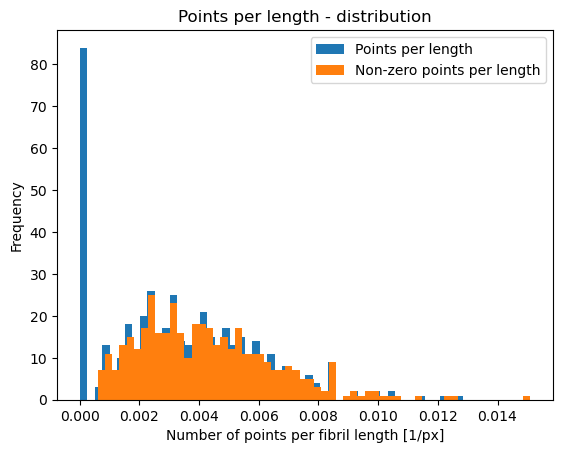

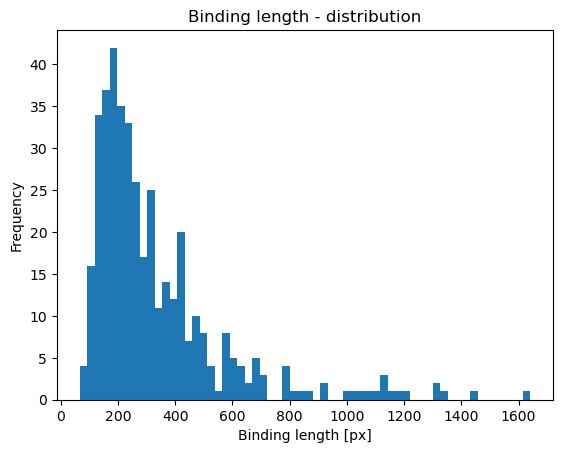

In [9]:
coloc_metrics = calculate_colocalization_metrics(
    points_layer=points_layer, shapes_layer=shapes_layer, num_images=num_images, dist_ths=dist_ths
)
print(f"Calculated: {coloc_metrics.keys()}")

points_per_length = coloc_metrics["points_per_length"]
points_per_length_non_zero = points_per_length[points_per_length > 0]

# non zero binding length:
binding_length= 1/points_per_length_non_zero # unit: px

print(f"Points per length:")
print(pd.Series(points_per_length).describe())

print(f"Points per lenght non-zero:")
print(pd.Series(points_per_length_non_zero).describe())

# Plot results:
plt.hist(points_per_length, bins=60, label="Points per length")
plt.hist(points_per_length[points_per_length > 0], bins=60, label="Non-zero points per length")
plt.xlabel("Number of points per fibril length [1/px]")
plt.ylabel("Frequency")
plt.title("Points per length - distribution")
plt.legend()
plt.show()


plt.hist(binding_length, bins=60)
plt.xlabel("Binding length [px]")
plt.ylabel("Frequency")
plt.title("Binding length - distribution")
plt.show()


Points per length in reasonable unit:

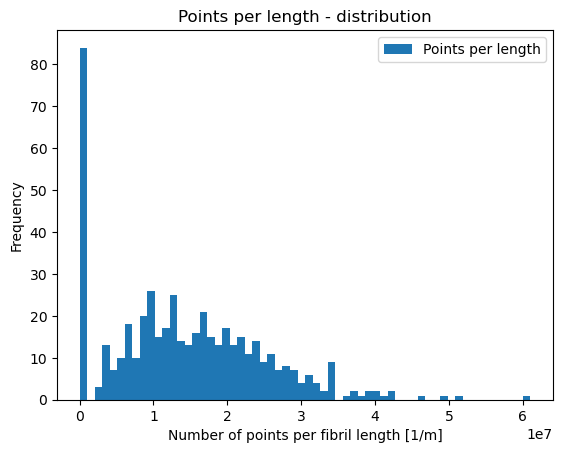

In [16]:
points_per_length_meter = points_per_length / PX_SIZE

plt.hist(points_per_length_meter, bins=60, label="Points per length")
plt.xlabel("Number of points per fibril length [1/m]")
plt.ylabel("Frequency")
plt.title("Points per length - distribution")
plt.legend()
plt.show()

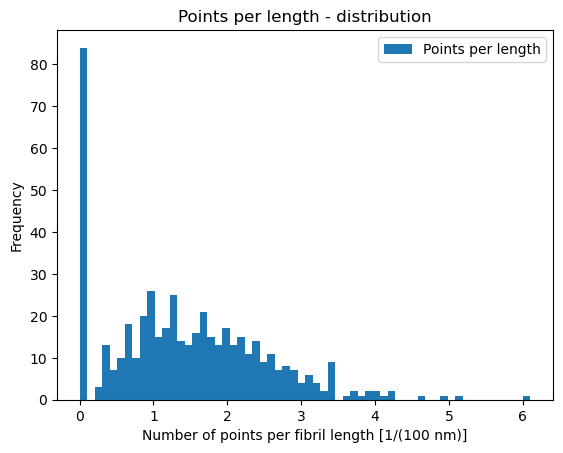

In [17]:
points_per_100nm = points_per_length_meter * 1e-7

plt.hist(points_per_100nm, bins=60, label="Points per length")
plt.xlabel("Number of points per fibril length [1/(100 nm)]")
plt.ylabel("Frequency")
plt.title("Points per length - distribution")
plt.legend()
plt.show()

In [18]:
viewer.close()

# Analysis for all immunogold datasets

## Calculate number of points per fibril length for all datasets

In [30]:
# All images file locations (saved in dictionary with sample describtion as keys):
ANGPIX = 2.475217  # pixel size in A for Talos CET 57k Magnification

mic_dir = Path(r"C:\Users\simon\OneDrive\Bilder\Microscopy\Talos_L120C\04_02_2025_Immunogold_paper_revision_figures")
coords_dir = Path("coordinate_data")

image_directories = {
    "tg-APP ArcSwe": mic_dir / Path("ArcSwe/Immunogold_ArcSwe_Lecanemab"),
    "APP23": mic_dir / Path("APP23/APP23_C7"),
    "tg-APP Swe": mic_dir / Path("Swe_8H/Swe_8H"),
    "APP/PS1": mic_dir / Path("APPPS1_Lecanemab_immunogold/APPPS1_Lecanemab_immunogold"),
    "ARTE10": mic_dir / Path("ARTE10_2H/ARTE10_2H"),
    "tg-SwDI": mic_dir / Path("SweDI/Immunogold_SweDI_Lecanemab"),
}
for dir in image_directories.values():
    assert dir.exists()

# All coordinate file locations:
point_coord_files = {
    "tg-APP ArcSwe": coords_dir / Path("ArcSwe_Lecanemab/Points ArcSwe.csv"),
    "APP23": coords_dir / Path("APP23_C7/Points_APP23.csv"),
    "tg-APP Swe": coords_dir / Path("Swe_8H/Points_all_files_merged_Swe-fixed.csv"),
    "APP/PS1": coords_dir / Path("APPPS1_Lecanemab/Points APPPS1.csv"),
    "ARTE10": coords_dir / Path("ARTE10_2H/Points_all_files_merged_ARTE10-fixed.csv"),
    "tg-SwDI": coords_dir / Path("SweDI_Lecanemab/Points_SwDI.csv")
}
for fp in point_coord_files.values():
    assert fp.exists()

line_coord_files = {
    "tg-APP ArcSwe": coords_dir / Path("ArcSwe_Lecanemab/Shapes ArcSwe.csv"),
    "APP23": coords_dir / Path("APP23_C7/Shapes_APP23.csv"),
    "tg-APP Swe": coords_dir / Path("Swe_8H/Shapes_all_files_merged_Swe-fixed.csv"),
    "APP/PS1": coords_dir / Path("APPPS1_Lecanemab/Shapes APPPS1.csv"),
    "ARTE10": coords_dir / Path("ARTE10_2H/Shapes_all_files_merged_ARTE10-fixed.csv"),  
    "tg-SwDI": coords_dir / Path("SweDI_Lecanemab/Shapes_SwDI.csv")
}
for fp in line_coord_files.values():
    assert fp.exists()


In [31]:
# iterate over all datasets:
points_per_length_dict = {}
for sample in image_directories.keys():
    print(f"\nSample: {sample}")

    # Read data:
    num_images, (viewer, points_layer, shapes_layer) = read_and_display_immunogold_fibril_data(
        images_dir=image_directories[sample],
        points_layer_csv_fp=point_coord_files[sample],
        shapes_layer_csv_fp=line_coord_files[sample],
        file_type_glob="*.png"
    )

    # Set default distance threshold:
    dist_ths = define_distance_threshold(points_layer=points_layer, shapes_layer=shapes_layer, angpix=ANGPIX)

    # Calculate points per length:

    coloc_metrics = calculate_colocalization_metrics(
        points_layer=points_layer, shapes_layer=shapes_layer, num_images=num_images, dist_ths=dist_ths
    )

    points_per_length = coloc_metrics["points_per_length"]

    points_per_length_meter = points_per_length / PX_SIZE
    points_per_100nm = points_per_length_meter * 1e-7

    points_per_length_dict[sample] = points_per_100nm
    print(f"Number of samples (i.e. fibrils): {len(points_per_100nm)}")



Sample: tg-APP ArcSwe
Number of images: 125
Gold NP diameter (Measured): 42 px = 103.95911399999999 A
Fibril width: 70 px = 173.26519 A
Primary-secondary antibody length (Literature): 121.20149465683212 px = 300 A
Distance threshold: 177.20149465683212 px = 438.612152 A
Number of samples (i.e. fibrils): 972

Sample: APP23
Number of images: 101
Gold NP diameter (Measured): 42 px = 103.95911399999999 A
Fibril width: 70 px = 173.26519 A
Primary-secondary antibody length (Literature): 121.20149465683212 px = 300 A
Distance threshold: 177.20149465683212 px = 438.612152 A
Number of samples (i.e. fibrils): 460

Sample: tg-APP Swe
Number of images: 112
Gold NP diameter (Measured): 42 px = 103.95911399999999 A
Fibril width: 70 px = 173.26519 A
Primary-secondary antibody length (Literature): 121.20149465683212 px = 300 A
Distance threshold: 177.20149465683212 px = 438.612152 A
Number of samples (i.e. fibrils): 492

Sample: APP/PS1
Number of images: 101
Gold NP diameter (Measured): 42 px = 103.9

In [21]:
points_per_length_greater_zero_dict = {sample: points_per_len[points_per_len > 0] for sample, points_per_len in points_per_length_dict.items()}

## Visualize the results and test for statistical significance

### Boxplots:

In [32]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm
from scipy import stats
from itertools import combinations

def plot_dictionary_boxplots(data_dict, figsize=(12, 8), title="Distribution of Values", 
                             colormap="viridis", rotate_labels=45, show_outliers=True,
                             show_significance=True, alpha=0.05, parametric=None,
                             reference_group=None):
    """
    Generate aesthetically pleasing vertical boxplots for a dictionary of arrays,
    with optional statistical significance testing between groups.
    
    Parameters:
    -----------
    data_dict : dict
        Dictionary where keys are strings and values are 1D arrays of floats
    figsize : tuple, optional
        Figure size as (width, height) in inches
    title : str, optional
        Title of the plot
    colormap : str, optional
        Matplotlib colormap name (e.g., 'viridis', 'plasma', 'coolwarm', 'tab10')
    rotate_labels : int, optional
        Rotation angle for x-axis labels (useful for long labels)
    show_outliers : bool, optional
        Whether to display outliers in the boxplots
    show_significance : bool, optional
        Whether to display significance markers between groups
    alpha : float, optional
        Significance level (default: 0.05)
    parametric : bool or None, optional
        If True, uses parametric tests (ANOVA + Tukey HSD)
        If False, uses non-parametric tests (Kruskal-Wallis + Dunn's test)
        If None, automatically determines based on Shapiro-Wilk normality test
    reference_group : str or None, optional
        If provided, only test significance between this group and all others
        If None, test significance between all possible group pairs
        
    Returns:
    --------
    fig, ax : matplotlib figure and axes objects
    """
    # Create figure and axes
    fig, ax = plt.subplots(figsize=figsize)
    
    # Prepare data for boxplot
    labels = list(data_dict.keys())
    data = [data_dict[key] for key in labels]
    
    # Generate colors from colormap (using modern Matplotlib API)
    # Handle both newer and older Matplotlib versions
    try:
        # For Matplotlib >= 3.7
        import matplotlib as mpl
        cmap = mpl.colormaps[colormap]
    except (AttributeError, KeyError):
        # Fallback for older Matplotlib versions
        cmap = cm.get_cmap(colormap)
    
    num_items = len(labels)
    colors = [cmap(i/num_items) for i in range(num_items)]
    
    # Set a nice background color
    ax.set_facecolor('#f8f8f8')
    
    # Create boxplot
    bp = ax.boxplot(data, 
                   patch_artist=True,    # Fill boxes with color
                   labels=labels,
                   vert=True,            # Vertical boxplots
                   widths=0.6,           # Width of boxes
                   showmeans=True,       # Show mean as a marker
                   showfliers=show_outliers,  # Show outliers
                   meanprops={"marker":"o", 
                              "markerfacecolor":"white", 
                              "markeredgecolor":"black",
                              "markersize":6},
                   medianprops={"color":"black", "linewidth":2},
                   flierprops={"marker":"o", 
                               "markerfacecolor":"none", 
                               "markeredgecolor":"gray", 
                               "markersize":4,
                               "alpha":0.7})
    
    # Color the boxes
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)  # Add some transparency
        patch.set_edgecolor('black')
        patch.set_linewidth(1.2)
    
    # Customize whiskers and caps
    for whisker, cap in zip(bp['whiskers'], bp['caps']):
        whisker.set_color('black')
        whisker.set_linewidth(1.2)
        cap.set_color('black')
        cap.set_linewidth(1.2)
    
    # Adjust x-axis labels rotation if needed
    plt.xticks(rotation=rotate_labels, ha='right' if rotate_labels > 0 else 'center')
    
    # Add sample size annotation for each group
    for i, (label, group_data) in enumerate(zip(labels, data)):
        sample_size = len(group_data)
        ax.text(i+1, ax.get_ylim()[0], f"n={sample_size}", 
                ha='center', va='top', fontsize=9, color='#555555',
                bbox=dict(facecolor='white', alpha=0.8, edgecolor='none', pad=1))
    
    # Add labels and title
    plt.title(title, fontsize=16, pad=20)
    plt.ylabel('Values', fontsize=13, labelpad=10)
    
    # Ensure grid is behind the plot elements
    ax.set_axisbelow(True)
    
    # Add a border to the plot
    for spine in ax.spines.values():
        spine.set_visible(True)
        spine.set_color('#dddddd')
    
    # Add a light horizontal grid
    ax.yaxis.grid(True, linestyle='--', alpha=0.7, color='#cccccc')
    
    # Calculate and display statistical significance
    if show_significance and len(data) > 1:
        # Determine if data is normally distributed if parametric is None
        if parametric is None:
            # Use Shapiro-Wilk test on each group to test for normality
            normal_data = True
            for group in data:
                # Use min(50, len(group)) samples to avoid very long computation
                sample_size = min(50, len(group))
                sample = np.random.choice(group, sample_size, replace=False)
                _, p_value = stats.shapiro(sample)
                if p_value < 0.05:  # If p < 0.05, data is not normally distributed
                    normal_data = False
                    break
            parametric = normal_data
        
        # Run appropriate statistical test based on parametric flag
        if parametric:
            # One-way ANOVA followed by Tukey HSD
            f_statistic, p_value = stats.f_oneway(*data)
            print(f"One-way ANOVA: F={f_statistic:.4f}, p={p_value:.4f}")
            
            # If overall significance, perform post-hoc Tukey HSD
            if p_value < alpha:
                # Create a single array and a group indicator array
                all_data = np.concatenate(data)
                group_indicator = np.concatenate([[i] * len(grp) for i, grp in enumerate(data)])
                
                # Perform Tukey HSD
                from statsmodels.stats.multicomp import pairwise_tukeyhsd
                tukey_results = pairwise_tukeyhsd(all_data, group_indicator, alpha=alpha)
                print("\nTukey HSD Results:")
                print(tukey_results)
                
                # Extract pairwise significance
                significant_pairs = []
                
                # Handle reference group if specified
                if reference_group is not None and reference_group in data_dict:
                    ref_idx = labels.index(reference_group)
                    for i, row in enumerate(tukey_results._results_table.data[1:]):
                        group1, group2, _, _, _, sig = row
                        # Only include pairs with the reference group
                        if (int(group1) == ref_idx or int(group2) == ref_idx) and sig:
                            significant_pairs.append((int(group1), int(group2), 
                                                     tukey_results.pvalues[i]))
                else:
                    # If no reference group or invalid reference, test all pairs
                    if reference_group is not None and reference_group not in data_dict:
                        print(f"Warning: Reference group '{reference_group}' not found in data. Testing all pairs.")
                    
                    for i, row in enumerate(tukey_results._results_table.data[1:]):
                        group1, group2, _, _, _, sig = row
                        if sig:
                            significant_pairs.append((int(group1), int(group2), 
                                                     tukey_results.pvalues[i]))
        else:
            # Kruskal-Wallis H-test (non-parametric ANOVA)
            h_statistic, p_value = stats.kruskal(*data)
            print(f"Kruskal-Wallis H-test: H={h_statistic:.4f}, p={p_value:.4f}")
            
            # If overall significance, perform post-hoc tests
            if p_value < alpha:
                significant_pairs = []
                
                # Handle reference group if specified
                if reference_group is not None and reference_group in data_dict:
                    ref_idx = labels.index(reference_group)
                    ref_data = data[ref_idx]
                    
                    # Test only between reference group and others
                    for i, group in enumerate(data):
                        if i != ref_idx:
                            u_statistic, p_corrected = stats.mannwhitneyu(ref_data, group)
                            # Apply Bonferroni correction
                            p_corrected *= (len(data) - 1)  # Only comparing to n-1 groups
                            p_corrected = min(p_corrected, 1.0)  # Cap at 1.0
                            
                            if p_corrected < alpha:
                                significant_pairs.append((ref_idx, i, p_corrected))
                                print(f"Significant: {labels[ref_idx]} vs {labels[i]}, p={p_corrected:.4f}")
                else:
                    # If no reference group or invalid reference, test all pairs
                    if reference_group is not None and reference_group not in data_dict:
                        print(f"Warning: Reference group '{reference_group}' not found in data. Testing all pairs.")
                    
                    # Perform pairwise Mann-Whitney U tests with Bonferroni correction
                    for (i, group1), (j, group2) in combinations(enumerate(data), 2):
                        u_statistic, p_corrected = stats.mannwhitneyu(group1, group2)
                        # Apply Bonferroni correction
                        p_corrected *= (len(data) * (len(data) - 1)) / 2
                        p_corrected = min(p_corrected, 1.0)  # Cap at 1.0
                        if p_corrected < alpha:
                            significant_pairs.append((i, j, p_corrected))
                            print(f"Significant: {labels[i]} vs {labels[j]}, p={p_corrected:.4f}")
        
        # Add significance markers to the plot
        if p_value < alpha:
            # Get positions of boxes
            positions = np.arange(1, len(labels) + 1)
            
            # Define height step for multiple comparisons
            y_max = max([max(group) for group in data if len(group) > 0])
            y_min = min([min(group) for group in data if len(group) > 0])
            y_range = y_max - y_min
            step = y_range * 0.07
            
            # Track used heights to avoid overlap
            used_heights = {}
            
            try:
                # Draw significance markers
                for i, j, p_val in significant_pairs:
                    # Calculate height of significance bar
                    if (i, j) in used_heights:
                        height = used_heights[(i, j)]
                    else:
                        height = y_max + step * (1 + len(used_heights) // (len(labels) - 1))
                        used_heights[(i, j)] = height
                    
                    # Convert significance to stars
                    if p_val < 0.001:
                        stars = '***'
                    elif p_val < 0.01:
                        stars = '**'
                    elif p_val < 0.05:
                        stars = '*'
                    else:
                        stars = 'ns'
                    
                    # Draw the line
                    x1, x2 = positions[i], positions[j]
                    line_color = '#555555'  # Dark gray for the significance lines
                    ax.plot([x1, x1, x2, x2], [height - step/2, height, height, height - step/2], 
                            lw=1.5, c=line_color)
                    
                    # Add text with significance
                    ax.text((x1 + x2) / 2, height, stars, ha='center', va='bottom', 
                           color=line_color, fontsize=12, fontweight='bold')
            except Exception as e:
                print(f"Error drawing significance markers: {e}")
                # Fall back to just printing results if visualization fails
                pass
            
            # Update y-axis limits to accommodate significance markers
            if used_heights:
                max_height = max(used_heights.values()) + step
                current_bottom, current_top = ax.get_ylim()
                ax.set_ylim(current_bottom, max(current_top, max_height + step * 2))
    
    # Add legend for significance if applicable
    if show_significance and p_value < alpha:
        from matplotlib.lines import Line2D
        line_color = '#555555'  # Match the significance lines color
        legend_elements = [
            Line2D([0], [0], color=line_color, linewidth=1.5, label='* p < 0.05'),
            Line2D([0], [0], color=line_color, linewidth=1.5, label='** p < 0.01'),
            Line2D([0], [0], color=line_color, linewidth=1.5, label='*** p < 0.001')
        ]
        ax.legend(handles=legend_elements, loc='upper right',
                 frameon=True, framealpha=0.7, fontsize=10)
    
    # Tight layout to ensure everything fits
    plt.tight_layout()
    
    return fig, ax

# # Example usage:
# if __name__ == "__main__":
#     # Create a sample dictionary
#     np.random.seed(42)  # For reproducibility
#     example_dict = {
#         'Control': np.random.normal(0, 1, 100),
#         'Treatment A': np.random.normal(2, 0.5, 100),  # Different mean
#         'Treatment B': np.random.normal(0, 1, 100),    # Same as Control
#         'Treatment C': np.random.exponential(1, 100),  # Different distribution
#         'Treatment D': np.random.normal(0, 3, 100)     # Same mean as Control but different variance
#     }
    
#     # Generate the boxplot with significance testing against a reference group
#     fig, ax = plot_dictionary_boxplots(
#         example_dict,
#         title="Example: Distribution Comparison with Statistical Significance",
#         colormap="coolwarm",
#         show_significance=True,
#         alpha=0.05,  # 5% significance level
#         parametric=None,  # Auto-detect
#         reference_group='Control'  # Compare all treatments against Control
#     )
    
#     plt.show()

In [33]:
y_label = "Au particles per fibril length [1/(100 nm)]"

Kruskal-Wallis H-test: H=739.8230, p=0.0000
Significant: tg-APP ArcSwe vs APP23, p=0.0000
Significant: tg-APP ArcSwe vs tg-APP Swe, p=0.0000
Significant: tg-APP ArcSwe vs APP/PS1, p=0.0000
Significant: tg-APP ArcSwe vs ARTE10, p=0.0000
Significant: tg-APP ArcSwe vs tg-SwDI, p=0.0000
Significant: APP23 vs tg-APP Swe, p=0.0012
Significant: APP23 vs ARTE10, p=0.0000
Significant: APP23 vs tg-SwDI, p=0.0000
Significant: tg-APP Swe vs ARTE10, p=0.0000
Significant: tg-APP Swe vs tg-SwDI, p=0.0000
Significant: APP/PS1 vs ARTE10, p=0.0000
Significant: APP/PS1 vs tg-SwDI, p=0.0000
Significant: ARTE10 vs tg-SwDI, p=0.0000


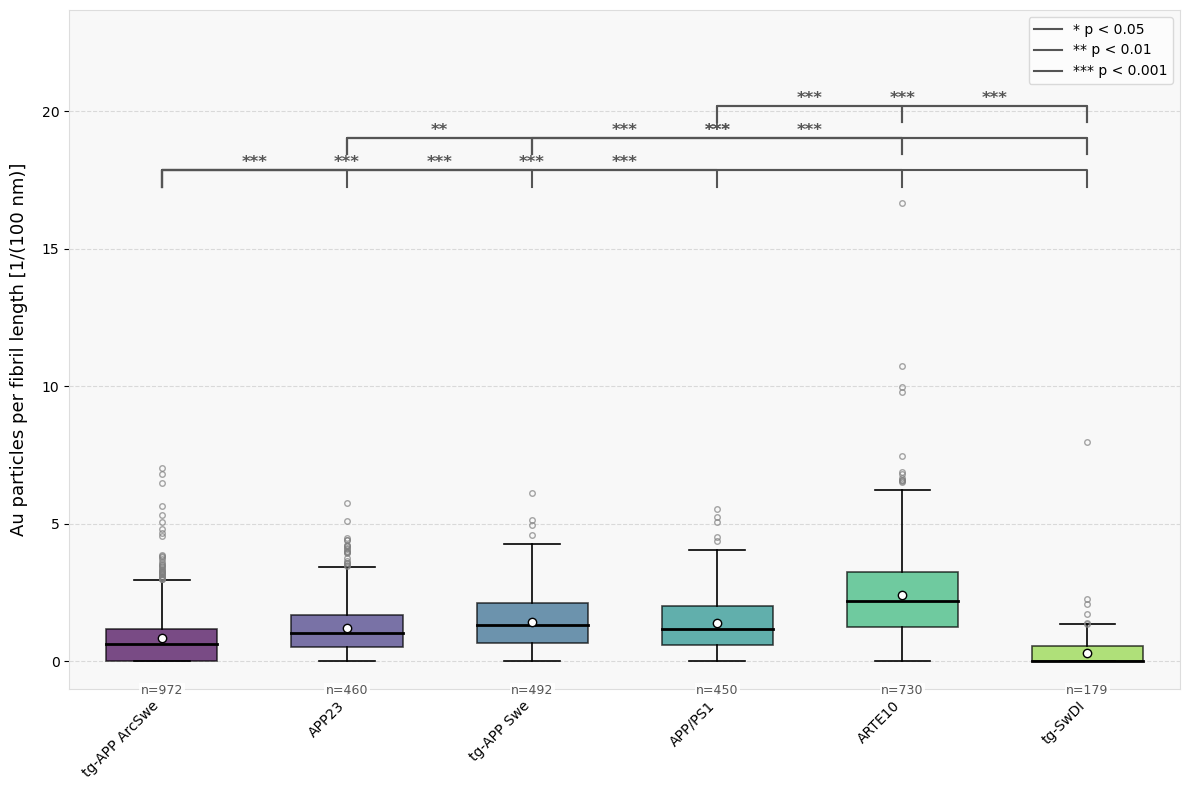

In [34]:
# Generate the plot
fig, ax = plot_dictionary_boxplots(points_per_length_dict, title=None, reference_group="SweDI")
ax.set_ylabel(y_label)

# Save or show the plot
plt.savefig("points_per_length_boxplots.svg", dpi=300)
plt.show()

Kruskal-Wallis H-test: H=542.7971, p=0.0000
Significant: tg-APP ArcSwe vs APP23, p=0.0018
Significant: tg-APP ArcSwe vs tg-APP Swe, p=0.0000
Significant: tg-APP ArcSwe vs APP/PS1, p=0.0000
Significant: tg-APP ArcSwe vs ARTE10, p=0.0000
Significant: tg-APP ArcSwe vs tg-SwDI, p=0.0374
Significant: APP23 vs tg-APP Swe, p=0.0000
Significant: APP23 vs APP/PS1, p=0.0259
Significant: APP23 vs ARTE10, p=0.0000
Significant: APP23 vs tg-SwDI, p=0.0000
Significant: tg-APP Swe vs ARTE10, p=0.0000
Significant: tg-APP Swe vs tg-SwDI, p=0.0000
Significant: APP/PS1 vs ARTE10, p=0.0000
Significant: APP/PS1 vs tg-SwDI, p=0.0000
Significant: ARTE10 vs tg-SwDI, p=0.0000


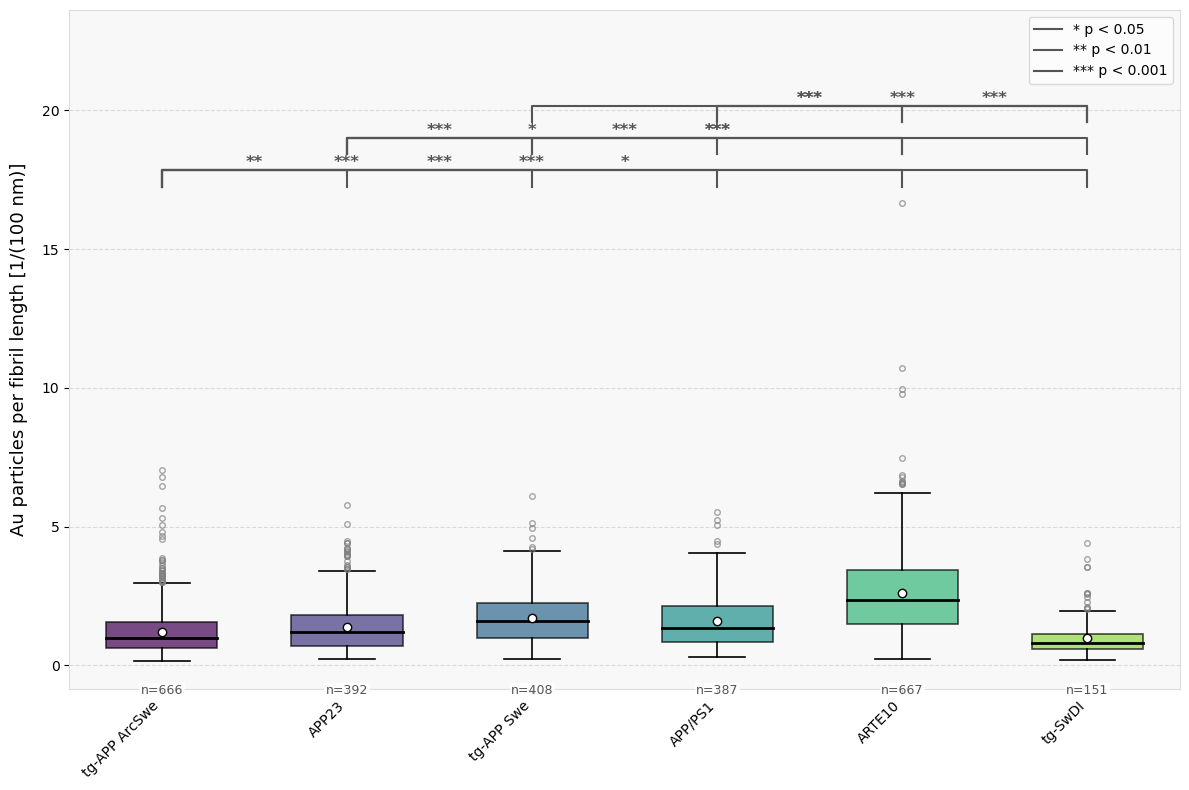

In [25]:
fig, ax = plot_dictionary_boxplots(points_per_length_greater_zero_dict, title=None, reference_group="SweDI")
ax.set_ylabel(y_label)

# Save or show the plot
plt.savefig("points_per_length_greater_zero_boxplots.svg", dpi=300)
plt.show()

### Violin plots

In [35]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as mcolors
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.cm as cm
from scipy import stats
from itertools import combinations
from statsmodels.stats.multicomp import pairwise_tukeyhsd


def filter_outliers_from_data(data, iqr_factor=1.5):
    """
    Filter outliers from data groups based on IQR method.
    
    Parameters:
    -----------
    data : list of arrays
        List of 1D arrays containing data for each group
    iqr_factor : float, optional
        Factor to multiply the IQR by when determining outliers
        
    Returns:
    --------
    filtered_data : list of arrays
        Data with outliers removed
    outlier_counts : list of int
        Number of outliers removed from each group
    """
    filtered_data = data.copy()
    outlier_counts = []
    
    for i, group in enumerate(data):
        if len(group) > 4:  # Only filter if we have enough data points
            q1, q3 = np.percentile(group, [25, 75])
            iqr = q3 - q1
            lower_bound = q1 - (iqr_factor * iqr)
            upper_bound = q3 + (iqr_factor * iqr)
            
            # Filter outliers
            mask = (group >= lower_bound) & (group <= upper_bound)
            filtered_group = group[mask]
            
            # Count outliers
            outlier_count = len(group) - len(filtered_group)
            outlier_counts.append(outlier_count)
            
            # Replace with filtered data for visualization
            filtered_data[i] = filtered_group
        else:
            # If too few points, don't filter
            outlier_counts.append(0)
            
    return filtered_data, outlier_counts


def get_colormap(colormap_name):
    """Get colormap using the appropriate Matplotlib API."""
    try:
        # For Matplotlib >= 3.7
        import matplotlib as mpl
        cmap = mpl.colormaps[colormap_name]
    except (AttributeError, KeyError):
        # Fallback for older Matplotlib versions
        cmap = cm.get_cmap(colormap_name)
    return cmap


def create_violin_plot(ax, data, positions, colors):
    """
    Create and style the violin plot.
    
    Parameters:
    -----------
    ax : matplotlib axes
        Axes to plot on
    data : list of arrays
        List of 1D arrays containing data for each group
    positions : array
        Positions for each violin
    colors : list
        List of colors for each violin
        
    Returns:
    --------
    violin_parts : dict
        The violin parts dictionary returned by ax.violinplot
    """
    # Create violin plot
    violin_parts = ax.violinplot(data, positions=positions, 
                              showmeans=True, showmedians=True, showextrema=True)
    
    # Style the violins
    for i, pc in enumerate(violin_parts['bodies']):
        pc.set_facecolor(colors[i])
        pc.set_edgecolor('#555555')
        pc.set_alpha(0.7)
        pc.set_linewidth(1)
    
    # Style the lines
    for key in ['cmeans', 'cmaxes', 'cmins', 'cbars', 'cmedians']:
        if key in violin_parts:
            if key == 'cmeans':
                violin_parts[key].set_color('#333333')
                violin_parts[key].set_linewidth(1.5)
            elif key == 'cmedians':
                violin_parts[key].set_color('#000000')
                violin_parts[key].set_linewidth(2)
            else:
                violin_parts[key].set_color('#555555')
                violin_parts[key].set_linewidth(1)
    
    return violin_parts


def add_data_points(ax, data, positions, jitter_width=0.08):
    """Add individual data points to the plot with jitter."""
    for i, group in enumerate(data):
        # Add jitter to x position
        x = np.random.normal(positions[i], jitter_width, size=len(group))
        # Plot points
        ax.scatter(x, group, s=15, c='#333333', alpha=0.4, edgecolor='none')


def add_quartile_lines(ax, data, positions):
    """Add horizontal lines for quartiles within each violin."""
    quartile_width = 0.1
    for i, d in enumerate(data):
        if len(d) > 0:  # Ensure we have data points
            pos = positions[i]
            # Calculate quartiles
            q1, median, q3 = np.percentile(d, [25, 50, 75])
            
            # Add Q1 and Q3 lines
            ax.plot([pos - quartile_width, pos + quartile_width], [q1, q1], 
                    linestyle='-', linewidth=1.5, color='#333333', alpha=0.8)
            ax.plot([pos - quartile_width, pos + quartile_width], [q3, q3], 
                    linestyle='-', linewidth=1.5, color='#333333', alpha=0.8)


def add_sample_size_annotations(ax, data, positions, outlier_counts=None):
    """Add sample size annotations for each group."""
    for i, group_data in enumerate(data):
        sample_size = len(group_data)
        annotation_text = f"n={sample_size}"
        
        ax.text(positions[i], ax.get_ylim()[0], annotation_text, 
                ha='center', va='top', fontsize=11*1.5, color='#555555',
                bbox=dict(facecolor='white', alpha=0.8, edgecolor='none', pad=1))


def run_parametric_tests(data, labels, alpha=0.05, reference_group=None):
    """
    Run parametric statistical tests (ANOVA + Tukey HSD).
    
    Returns:
    --------
    p_value : float
        The overall p-value from ANOVA
    significant_pairs : list of tuples
        List of (i, j, p_value) tuples for significant pairs
    """
    # One-way ANOVA
    f_statistic, p_value = stats.f_oneway(*data)
    print(f"One-way ANOVA: F={f_statistic:.4f}, p={p_value:.4f}")
    
    significant_pairs = []
    
    # If overall significance, perform post-hoc Tukey HSD
    if p_value < alpha:
        # Create a single array and a group indicator array
        all_data = np.concatenate(data)
        group_indicator = np.concatenate([[i] * len(grp) for i, grp in enumerate(data)])
        
        # Perform Tukey HSD
        tukey_results = pairwise_tukeyhsd(all_data, group_indicator, alpha=alpha)
        print("\nTukey HSD Results:")
        print(tukey_results)
        
        # Handle reference group if specified
        if reference_group is not None and reference_group in labels:
            ref_idx = labels.index(reference_group)
            for i, row in enumerate(tukey_results._results_table.data[1:]):
                group1, group2, _, _, _, sig = row
                # Only include pairs with the reference group
                if (int(group1) == ref_idx or int(group2) == ref_idx) and sig:
                    significant_pairs.append((int(group1), int(group2), 
                                             tukey_results.pvalues[i]))
        else:
            # Test all pairs
            if reference_group is not None and reference_group not in labels:
                print(f"Warning: Reference group '{reference_group}' not found in data. Testing all pairs.")
            
            for i, row in enumerate(tukey_results._results_table.data[1:]):
                group1, group2, _, _, _, sig = row
                if sig:
                    significant_pairs.append((int(group1), int(group2), 
                                             tukey_results.pvalues[i]))
    
    return p_value, significant_pairs


def run_nonparametric_tests(data, labels, alpha=0.05, reference_group=None):
    """
    Run non-parametric statistical tests (Kruskal-Wallis + Mann-Whitney U).
    
    Returns:
    --------
    p_value : float
        The overall p-value from Kruskal-Wallis
    significant_pairs : list of tuples
        List of (i, j, p_value) tuples for significant pairs
    """
    # Kruskal-Wallis H-test
    h_statistic, p_value = stats.kruskal(*data)
    print(f"Kruskal-Wallis H-test: H={h_statistic:.4f}, p={p_value:.4f}")
    
    significant_pairs = []
    
    # If overall significance, perform post-hoc tests
    if p_value < alpha:
        # Handle reference group if specified
        if reference_group is not None and reference_group in labels:
            ref_idx = labels.index(reference_group)
            ref_data = data[ref_idx]
            
            # Test only between reference group and others
            for i, group in enumerate(data):
                if i != ref_idx:
                    u_statistic, p_corrected = stats.mannwhitneyu(ref_data, group)
                    # Apply Bonferroni correction
                    p_corrected *= (len(data) - 1)  # Only comparing to n-1 groups
                    p_corrected = min(p_corrected, 1.0)  # Cap at 1.0
                    
                    if p_corrected < alpha:
                        significant_pairs.append((ref_idx, i, p_corrected))
                        print(f"Significant: {labels[ref_idx]} vs {labels[i]}, p={p_corrected:.4f}")
        else:
            # Test all pairs
            if reference_group is not None and reference_group not in labels:
                print(f"Warning: Reference group '{reference_group}' not found in data. Testing all pairs.")
            
            # Perform pairwise Mann-Whitney U tests with Bonferroni correction
            for (i, group1), (j, group2) in combinations(enumerate(data), 2):
                u_statistic, p_corrected = stats.mannwhitneyu(group1, group2)
                # Apply Bonferroni correction
                p_corrected *= (len(data) * (len(data) - 1)) / 2
                p_corrected = min(p_corrected, 1.0)  # Cap at 1.0
                if p_corrected < alpha:
                    significant_pairs.append((i, j, p_corrected))
                    print(f"Significant: {labels[i]} vs {labels[j]}, p={p_corrected:.4f}")
    
    return p_value, significant_pairs


def draw_significance_markers(ax, significant_pairs, positions, labels, reference_group=None):
    """
    Draw significance markers on the plot.
    
    Returns:
    --------
    max_height : float
        The maximum height used for significance markers
    """
    # Define height step for multiple comparisons
    y_min, y_max = ax.get_ylim()
    y_range = y_max - y_min
    step = y_range * 0.07
    
    # Start significance bars just above the top of the plot
    sig_start = y_max + (step * 0.5)
    
    # Track used heights to avoid overlap
    used_heights = {}
    line_color = '#555555'  # Dark gray for the significance lines
    
    try:
        # Draw significance markers
        for i, j, p_val in significant_pairs:
            # Calculate height of significance bar
            if (i, j) in used_heights:
                height = used_heights[(i, j)]
            else:
                height = sig_start + step * (len(used_heights) // (len(labels) - 1))
                used_heights[(i, j)] = height
            
            # Convert significance to stars
            if p_val < 0.001:
                stars = '***'
            elif p_val < 0.01:
                stars = '**'
            elif p_val < 0.05:
                stars = '*'
            else:
                stars = 'ns'
            
            # Draw the line
            x1, x2 = positions[i], positions[j]
            
            # Check if reference_group is not None
            if reference_group is not None and reference_group in labels:
                # Draw horizontal line
                ax.plot([x1, x2], [height, height], lw=1.5, c=line_color)
                
                # Draw vertical lines to each violin
                ax.plot([x1, x1], [height - step/2, height], lw=1.5, c=line_color)
                ax.plot([x2, x2], [height - step/2, height], lw=1.5, c=line_color)
                
                # Get reference group index
                ref_idx = labels.index(reference_group)
                
                # Add significance stars beside the non-reference group's vertical line
                if i == ref_idx:
                    # Add star to the right vertical line (j)
                    ax.text(x2 - 0.05, height - step*0.7, stars, ha='right', va='center', 
                          color=line_color, fontsize=12*1.5, fontweight='bold')
                elif j == ref_idx:
                    # Add star to the left vertical line (i)
                    ax.text(x1 + 0.05, height - step*0.7, stars, ha='left', va='center', 
                          color=line_color, fontsize=12*1.5, fontweight='bold')
                else:
                    # If neither is the reference (shouldn't happen with reference_group set)
                    # Add to both sides for completeness
                    ax.text(x1 + 0.05, height - step*0.7, stars, ha='left', va='center', 
                          color=line_color, fontsize=12*1.5, fontweight='bold')
                    ax.text(x2 - 0.05, height - step*0.7, stars, ha='right', va='center', 
                          color=line_color, fontsize=12*1.5, fontweight='bold')
            else:
                # Use the original style with p-value indicators in the middle
                ax.plot([x1, x1, x2, x2], [height - step/2, height, height, height - step/2], 
                        lw=1.5, c=line_color)
                
                # Add text with significance in the middle of the horizontal line
                ax.text((x1 + x2) / 2, height, stars, ha='center', va='bottom', 
                       color=line_color, fontsize=12*1.5, fontweight='bold')
                
    except Exception as e:
        print(f"Error drawing significance markers: {e}")
    
    # Return the maximum height used for significance markers
    return max(used_heights.values()) + step if used_heights else 0


def add_significance_legend(ax, line_color='#555555'):
    """Add legend for significance markers."""
    from matplotlib.lines import Line2D
    legend_elements = [
        Line2D([0], [0], color=line_color, linewidth=1.5, label='* p < 0.05'),
        Line2D([0], [0], color=line_color, linewidth=1.5, label='** p < 0.01'),
        Line2D([0], [0], color=line_color, linewidth=1.5, label='*** p < 0.001')
    ]
    
    # Place legend outside the plot area
    legend = ax.legend(
        handles=legend_elements, 
        loc='upper center',
        frameon=True, 
        framealpha=0.9,
        edgecolor='#cccccc',
        fontsize=10*1.5,
        borderpad=1.0,
        bbox_to_anchor=(0.5, 1.15),  # Center, above the plot
        bbox_transform=ax.transAxes,
        ncol=3  # Arrange items horizontally
    )
    
    # Make sure legend stands out better visually
    legend.get_frame().set_linewidth(0.8)


def style_plot(ax, title, rotate_labels=45):
    """Apply final styling to the plot."""
    # Set a nice background color:
    # ax.set_facecolor('#f8f8f8')  # <--- Set background to gray
    ax.set_facecolor('white')
    
    # Adjust x-axis labels rotation if needed
    plt.xticks(rotation=rotate_labels, ha='right' if rotate_labels > 0 else 'center')
    
    # Increase font size for tick labels
    ax.tick_params(axis='both', labelsize=12*1.5)
    
    # Add more padding between labels and plot
    ax.tick_params(axis='x', pad=10*1.5)
    
    # Add labels and title with increased font sizes
    plt.title(title, fontsize=16*1.5, pad=20)
    plt.ylabel('Values', fontsize=13*1.5, labelpad=10)
    
    # Ensure grid is behind the plot elements
    ax.set_axisbelow(True)
    
    # Add a border to the plot
    for spine in ax.spines.values():
        spine.set_visible(True)
        spine.set_color('#dddddd')
    
    # Add a light horizontal grid
    ax.yaxis.grid(True, linestyle='--', alpha=0.7, color='#cccccc')


def adjust_plot_layout():
    """Adjust plot layout to ensure everything fits."""
    # Tight layout with extra padding
    # plt.tight_layout(pad=1.2, h_pad=1.5, w_pad=1.5, rect=[0, 0.05, 1, 0.9])
    plt.tight_layout()


def test_normality(data, sample_limit=50):
    """
    Test if data is normally distributed using Shapiro-Wilk test.
    
    Returns:
    --------
    normal_data : bool
        True if all groups appear to be normally distributed
    """
    normal_data = True
    for group in data:
        # Use min(sample_limit, len(group)) samples to avoid very long computation
        sample_size = min(sample_limit, len(group))
        sample = np.random.choice(group, sample_size, replace=False)
        _, p_value = stats.shapiro(sample)
        if p_value < 0.05:  # If p < 0.05, data is not normally distributed
            normal_data = False
            break
    return normal_data


# Modified function to use a custom colormap from a list of hex codes
def get_colormap(colormap_name_or_colors):
    """
    Get colormap using the appropriate Matplotlib API or create a custom one from hex colors.
    
    Parameters:
    -----------
    colormap_name_or_colors : str or list
        Either a string with a matplotlib colormap name or a list of hex color codes
        
    Returns:
    --------
    cmap : matplotlib colormap
    """
    # Check if we have a list of colors instead of a colormap name
    if isinstance(colormap_name_or_colors, list):
        # Create a custom colormap from hex colors
        hex_colors = colormap_name_or_colors
        rgb_colors = [mcolors.to_rgb(color) for color in hex_colors]
        return LinearSegmentedColormap.from_list('custom_cmap', rgb_colors)
    else:
        # Original implementation for standard colormaps
        try:
            # For Matplotlib >= 3.7
            import matplotlib as mpl
            cmap = mpl.colormaps[colormap_name_or_colors]
        except (AttributeError, KeyError):
            # Fallback for older Matplotlib versions
            cmap = cm.get_cmap(colormap_name_or_colors)
        return cmap

def plot_dictionary_violinplots(data_dict, figsize=(12, 8), title="Distribution of Values", 
                             colormap="viridis", rotate_labels=45, show_points=True,
                             show_significance=True, alpha=0.05, parametric=None,
                             reference_group=None, filter_outliers=False, iqr_factor=1.5):
    """
    Generate aesthetically pleasing vertical violin plots for a dictionary of arrays,
    with optional statistical significance testing between groups.
    
    Parameters:
    -----------
    data_dict : dict
        Dictionary where keys are strings and values are 1D arrays of floats
    figsize : tuple, optional
        Figure size as (width, height) in inches
    title : str, optional
        Title of the plot
    colormap : str or list, optional
        Either a Matplotlib colormap name (e.g., 'viridis', 'plasma', 'coolwarm', 'tab10')
        or a list of hex color codes (e.g., ['#FF0000', '#00FF00', '#0000FF'])
    rotate_labels : int, optional
        Rotation angle for x-axis labels (useful for long labels)
    show_points : bool, optional
        Whether to display individual data points (jittered to avoid overlap)
    show_significance : bool, optional
        Whether to display significance markers between groups
    alpha : float, optional
        Significance level (default: 0.05)
    parametric : bool or None, optional
        If True, uses parametric tests (ANOVA + Tukey HSD)
        If False, uses non-parametric tests (Kruskal-Wallis + Dunn's test)
        If None, automatically determines based on Shapiro-Wilk normality test
    reference_group : str or None, optional
        If provided, only test significance between this group and all others
        If None, test significance between all possible group pairs
    filter_outliers : bool, optional
        If True, removes outliers from the violin plots (but keeps them for statistics)
    iqr_factor : float, optional
        Factor to multiply the IQR by when determining outliers (default: 1.5)
        
    Returns:
    --------
    fig, ax : matplotlib figure and axes objects
    """
    # Create figure and axes
    fig, ax = plt.subplots(figsize=figsize)
    
    # Prepare data for violin plot
    labels = list(data_dict.keys())
    data = [data_dict[key] for key in labels]
    
    # Filter outliers if requested (for visualization only)
    if filter_outliers:
        filtered_data, outlier_counts = filter_outliers_from_data(data, iqr_factor)
    else:
        filtered_data = data
        outlier_counts = [0] * len(data)
    
    # Generate colors from colormap
    cmap = get_colormap(colormap)
    num_items = len(labels)
    colors = [cmap(i/max(1, num_items-1)) for i in range(num_items)]
    
    # Set up positions for violins
    positions = np.arange(1, len(labels) + 1)
    
    # Create and style the violin plot
    violin_parts = create_violin_plot(ax, filtered_data, positions, colors)
    
    # Add individual data points if requested
    if show_points:
        add_data_points(ax, filtered_data, positions)
    
    # Add quartile lines
    add_quartile_lines(ax, filtered_data, positions)
    
    # Set x-ticks with labels
    ax.set_xticks(positions)
    ax.set_xticklabels(labels)
    
    # Add sample size annotations
    add_sample_size_annotations(ax, data, positions, outlier_counts)
    
    # Apply base styling to the plot
    style_plot(ax, title, rotate_labels)
    
    # Perform statistical tests if requested
    if show_significance and len(data) > 1:
        # Determine if data is normally distributed if parametric is None
        if parametric is None:
            parametric = test_normality(data)
        
        # Run appropriate statistical test
        if parametric:
            p_value, significant_pairs = run_parametric_tests(
                data, labels, alpha, reference_group)
        else:
            p_value, significant_pairs = run_nonparametric_tests(
                data, labels, alpha, reference_group)
        
        # Adjust y-axis range to filtered data if outlier filtering is enabled
        if filter_outliers:
            all_filtered = np.concatenate([arr for arr in filtered_data if len(arr) > 0])
            if len(all_filtered) > 0:
                data_min = np.min(all_filtered)
                data_max = np.max(all_filtered)
                data_range = data_max - data_min
                
                # Add padding (5% on each side)
                padding = data_range * 0.05
                ax.set_ylim(data_min - padding, data_max + padding)
        
        # Add significance markers if the overall test was significant
        if p_value < alpha:
            max_height = draw_significance_markers(
                ax, significant_pairs, positions, labels, reference_group)
            
            # Update y-axis limits to accommodate significance markers
            current_bottom, current_top = ax.get_ylim()
            step = (current_top - current_bottom) * 0.07
            new_top = max_height + step
            ax.set_ylim(current_bottom, new_top)
            
            # Add significance legend
            add_significance_legend(ax)
    
    # Adjust layout for the final plot
    adjust_plot_layout()
    
    return fig, ax


# # Example usage with custom hex colors:
# if __name__ == "__main__":
#     # Create a sample dictionary with some statistically different groups
#     np.random.seed(42)  # For reproducibility
    
#     # Create data with deliberate outliers
#     control_data = np.random.normal(0, 1, 100)
#     control_data = np.append(control_data, [5, 5.2, 5.5, -5.3, 20])  # Add outliers
    
#     example_dict = {
#         'Control': control_data,
#         'Treatment A': np.random.normal(2, 0.5, 100),  # Different mean
#         'Treatment B': np.random.normal(0, 1, 100),    # Same as Control
#         'Treatment C': np.random.exponential(1, 100),  # Different distribution
#         'Treatment D': np.random.normal(0, 3, 100)     # Same mean as Control but different variance
#     }
    
#     # List of custom hex colors
#     custom_colors = ['#4A6FE3', '#D92B04', '#2E8B57', '#9932CC', '#FF8C00']
    
#     # Generate the violin plot with custom colors
#     fig, ax = plot_dictionary_violinplots(
#         example_dict,
#         title="Distribution Comparison with Custom Colors",
#         colormap=custom_colors,  # Pass the list of hex colors instead of a colormap name
#         show_points=True,
#         show_significance=True,
#         alpha=0.05,
#         reference_group="Control",
#         filter_outliers=True,
#         iqr_factor=1.5
#     )
    
#     plt.show()

Kruskal-Wallis H-test: H=739.8230, p=0.0000
Significant: tg-SwDI vs tg-APP ArcSwe, p=0.0000
Significant: tg-SwDI vs APP23, p=0.0000
Significant: tg-SwDI vs tg-APP Swe, p=0.0000
Significant: tg-SwDI vs APP/PS1, p=0.0000
Significant: tg-SwDI vs ARTE10, p=0.0000


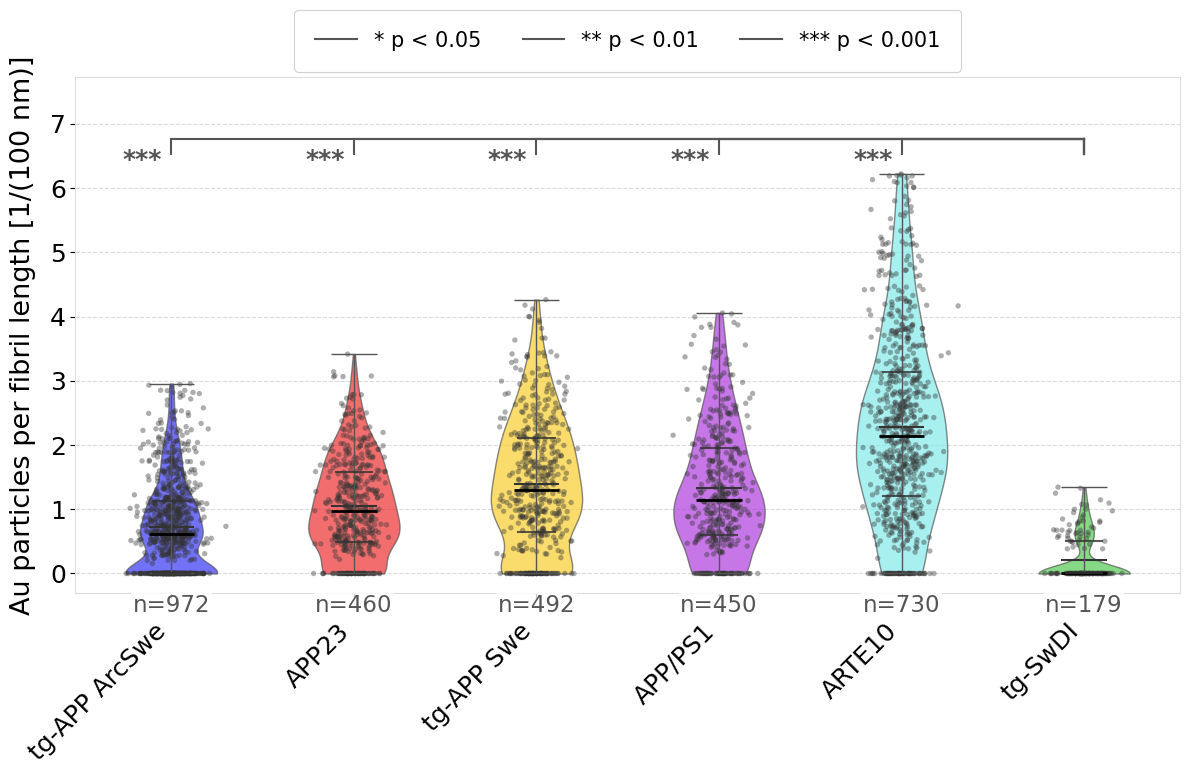

In [36]:
# Plot my data:

# Use color palette from Fig. 1:
custom_colors = ["#3636f6", "#ed3131", "#f8ce2f", "#af3cde", "#83eaea", "#53cb53"]


fig, ax = plot_dictionary_violinplots(points_per_length_dict, title=None, reference_group="tg-SwDI", filter_outliers=True, colormap=custom_colors)
ax.set_ylabel(y_label) 

# Save or show the plot:

fig.savefig("points_per_length_violinplot.svg")
plt.show()

Kruskal-Wallis H-test: H=739.8230, p=0.0000
Significant: tg-APP ArcSwe vs APP23, p=0.0000
Significant: tg-APP ArcSwe vs tg-APP Swe, p=0.0000
Significant: tg-APP ArcSwe vs APP/PS1, p=0.0000
Significant: tg-APP ArcSwe vs ARTE10, p=0.0000
Significant: tg-APP ArcSwe vs tg-SwDI, p=0.0000
Significant: APP23 vs tg-APP Swe, p=0.0012
Significant: APP23 vs ARTE10, p=0.0000
Significant: APP23 vs tg-SwDI, p=0.0000
Significant: tg-APP Swe vs ARTE10, p=0.0000
Significant: tg-APP Swe vs tg-SwDI, p=0.0000
Significant: APP/PS1 vs ARTE10, p=0.0000
Significant: APP/PS1 vs tg-SwDI, p=0.0000
Significant: ARTE10 vs tg-SwDI, p=0.0000


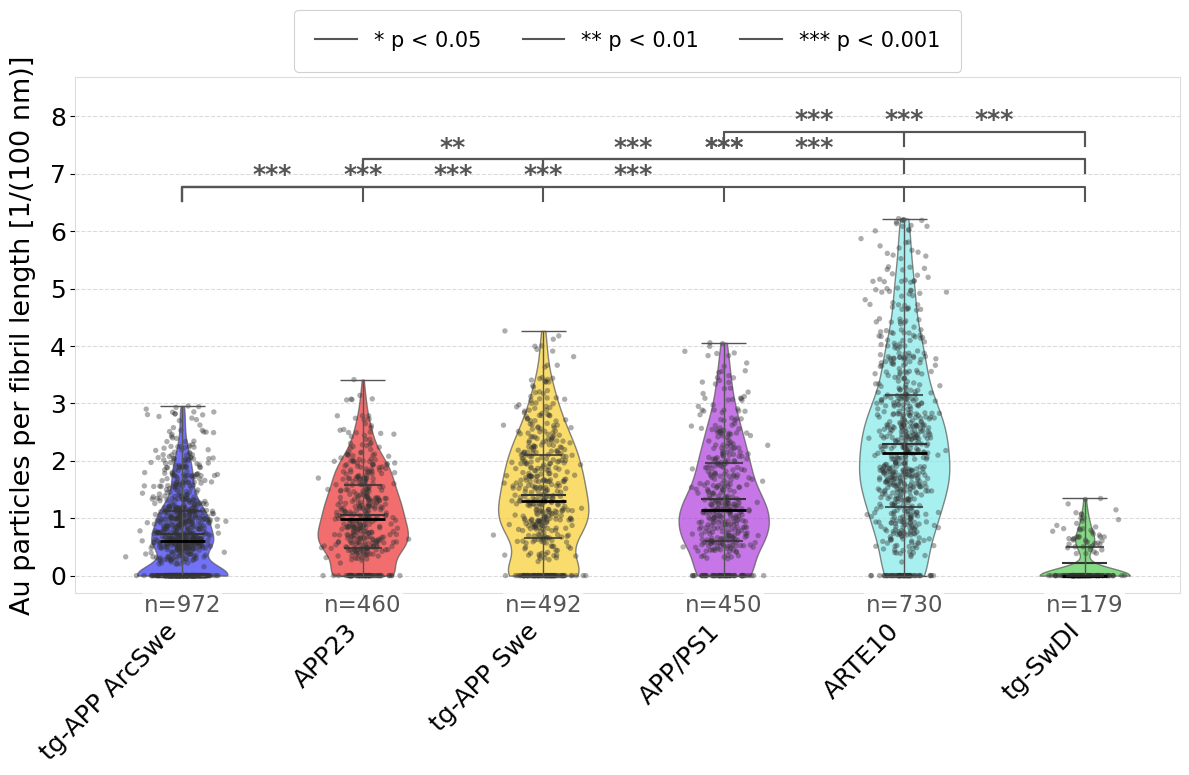

In [38]:
# Plot with pairwise significance testing:

# Use color palette from Fig. 1:
custom_colors = ["#3636f6", "#ed3131", "#f8ce2f", "#af3cde", "#83eaea", "#53cb53"]


fig, ax = plot_dictionary_violinplots(points_per_length_dict, title=None, filter_outliers=True, colormap=custom_colors)
ax.set_ylabel(y_label) 

# Save or show the plot:

fig.savefig("points_per_length_violinplot-pairwise.svg")
plt.show()

In [39]:
for sample, ppl_vals in points_per_length_dict.items():
    print(f"{sample}:")
    print(f"Mean: {ppl_vals.mean():.2f} particles per 100nm fibril (Std: {ppl_vals.std():.2f})")

tg-APP ArcSwe:
Mean: 0.84 particles per 100nm fibril (Std: 0.93)
APP23:
Mean: 1.19 particles per 100nm fibril (Std: 0.98)
tg-APP Swe:
Mean: 1.43 particles per 100nm fibril (Std: 1.06)
APP/PS1:
Mean: 1.37 particles per 100nm fibril (Std: 1.05)
ARTE10:
Mean: 2.39 particles per 100nm fibril (Std: 1.71)
tg-SwDI:
Mean: 0.30 particles per 100nm fibril (Std: 0.72)
